### Analyze Sensitivity Results

In [4]:
import os
import pandas as pd
res_dir = 'nb_hydr_static_v5_sssim_cali_exp_4_1'
cali_dir = 'cali_exp_4'
if not os.path.isdir(cali_dir):
    os.mkdir(cali_dir)
calibration_data_org = pd.read_csv('2020P2_calibration_data_30m.csv')
contents = os.listdir(base_res_dir)

In [5]:
import os
import pandas as pd
results = []

result_name = 'chw_sup_m.m_flow'
outputs = ['chw_sup_m.m_flow', 'chw_sup_P.p', 'terminal_resist.y_actual']
result_idx = outputs.index(result_name)
for content in contents:
    result_file_path = res_dir + os.sep + content + os.sep + 'sensi_sim_res.csv'
    result_pd = pd.read_csv(result_file_path, header = None)
    results.append(result_pd.values[:, result_idx])
print(len(results))

300


In [7]:
import numpy as np
# get calibration true data
# since each run may only randomly select a subset of calibration data, so each run has different calibration true data
calibration_datas = []

for content in contents:
    result_file_path = res_dir + os.sep + content + os.sep + 'random_indices.csv'
    indices_array = np.genfromtxt(result_file_path, delimiter=',', dtype = int)
    calibration_data_i = calibration_data_org.iloc[indices_array, :]
    calibration_datas.append(calibration_data_i)
print(len(calibration_datas))

300


In [8]:
# remove results with none
import numpy as np
val_idx = []
for i in range(len(results)):
    result_i = results[i]
    if np.isnan(result_i).sum() == 0:
        val_idx.append(i)
results_clean = [results[j] for j in val_idx]


val_idx_col = []
for i in range(np.array(results).shape[1]):
    result_i = np.array(results)[:, i]
    if np.isnan(result_i).sum() == 0:
        val_idx_col.append(i)
len(val_idx)

300

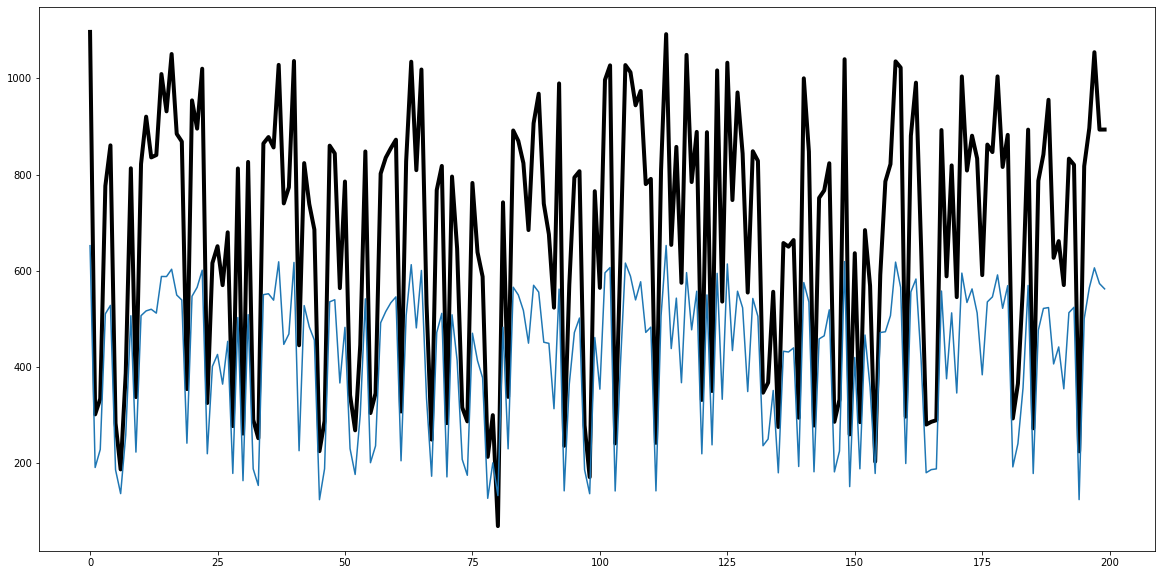

In [9]:
import matplotlib.pyplot as plt
import numpy as np
i = 31
fig, axs = plt.subplots(1, figsize = (20, 10))
axs.plot(calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values,
         color = 'k', linewidth = 4, label = 'True')
mapes = []
cvrmses = []
result_this = results_clean[i]
axs.plot(result_this, label = 'run_{}'.format(i))
mape_i = 100*(abs(calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values 
             - np.array(result_this))/\
             calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values).mean()
mapes.append(mape_i)
cvrmse_i = (((calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values 
             - np.array(result_this))**2).sum()/len(result_this))**0.5/\
            calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values.mean()
cvrmses.append(cvrmse_i)
    

In [10]:
def get_t(mo_path):
    chr_pipe_len = None
    chr_v_nom = None
    with open(mo_path) as file:
        lines = file.readlines()
        for line in lines:
            if 'parameter Real chiller_pipe_len=' in line:
                chr_pipe_len = float(line
                                     .split('parameter Real chiller_pipe_len=')[-1]
                                     .split('"m";')[0]
                                     .strip())
            if 'parameter Real chiller_v_nominal=' in line:
                chr_v_nom = float(line
                                     .split('parameter Real chiller_v_nominal=')[-1]
                                     .split('"m/s";')[0]
                                     .strip())
            if chr_pipe_len is not None and chr_v_nom is not None:
                break
    return chr_pipe_len, chr_v_nom
            

In [11]:
# prepare data files for calibration
mo_file_name = 'nb_hydr_static_v6.mo'
result_name = 'chw_sup_m.m_flow'
calibration_x_names = ['NB2_S_1_NYZ_sys_x_PcwOut_x','NB2_S_1_NYZ_sys_x_PcwIn_x',
             'NB2_S_1_NYZ_cwp_9_HzSPR_x','NB2_S_1_NYZ_cwp_10_HzSPR_x',
             'NB2_S_1_NYZ_cwp_11_HzSPR_x','NB2_S_1_NYZ_cwp_12_HzSPR_x']
outputs = ['chw_sup_m.m_flow', 'chw_sup_P.p', 'terminal_resist.y_actual']
result_idx = outputs.index(result_name)

for i in range(len(contents)):
    content = contents[i]
    # get the corresponding calibration data
    calibration_x = calibration_datas[i][calibration_x_names].values

    result_file_path = res_dir + os.sep + content + os.sep + 'sensi_sim_res.csv'
    result_pd = pd.read_csv(result_file_path, header = None)
    sim_y = result_pd.values[:, result_idx].reshape(-1, 1)
    cali_sim_data = np.concatenate((sim_y, calibration_x), axis = 1)
    mo_file_path = res_dir + os.sep + content\
                + os.sep + 'compilation'\
                + os.sep + mo_file_name
    chr_pipe_len, chr_v_nom = get_t(mo_file_path)
    sim_t = np.ones((sim_y.shape[0], 2)) * (chr_pipe_len, chr_v_nom)
    cali_sim_data = np.concatenate((cali_sim_data, sim_t), axis = 1)
    cali_sim_data = pd.DataFrame(cali_sim_data)
    column_names = ['m_flow_pred']
    column_names.extend(calibration_x_names)
    column_names.extend(['chiller_pipe_len', 'chiller_v_nominal'])
    cali_sim_data.columns = column_names
    cali_sim_data.to_csv(res_dir + os.sep + content + os.sep + 'cali_sim_data.csv', index=False)

In [12]:
# get all parameters of sensitivity analysis
import os
import pandas as pd
import numpy as np
parameters = []

for content in contents:

    data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
    data_i = pd.read_csv(data_file_path)
    parameters.append(data_i.values[0, -2: ])            
parameters = np.array(parameters)
print(parameters[val_idx])

[[100.044271     1.1854182 ]
 [ 49.77758972   1.07062641]
 [124.59418199   1.29422555]
 [108.1123945    1.34956789]
 [100.70939562   0.72059374]
 [ 85.80729148   1.60933182]
 [ 89.85582686   1.26406269]
 [100.45817555   1.89036315]
 [ 97.4355149    1.76646493]
 [ 58.39195466   1.4551719 ]
 [ 58.25715944   0.64332566]
 [ 87.86624506   1.2382597 ]
 [112.28815939   1.02854504]
 [145.17938559   0.83380646]
 [145.21656754   1.33209922]
 [ 93.96262717   1.41223523]
 [ 66.46872695   1.36905826]
 [109.39264833   1.21855173]
 [ 69.93656215   0.63606082]
 [ 75.14671383   1.11588954]
 [ 98.90250048   0.65343512]
 [135.24929572   1.24171513]
 [ 97.12142215   1.72293343]
 [126.64473902   1.08002099]
 [ 77.62912281   1.31044092]
 [147.06738683   0.89961044]
 [ 35.57431095   0.50061141]
 [119.194545     0.73997309]
 [104.28551116   0.72660429]
 [ 46.83155859   1.42421127]
 [135.06948191   1.51946403]
 [130.84754874   1.55831213]
 [146.67248454   1.17196364]
 [ 46.08647783   1.99636935]
 [ 65.6888145 

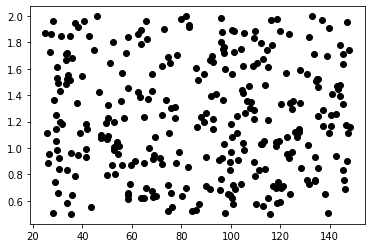

In [13]:
plt.scatter(parameters[:, 0], parameters[:, 1], color ='k')

In [14]:
# get a closer range for the parameters of sensitivity analysis
import os
import pandas as pd
import numpy as np
parameters = []
narrowed_run_dirs = []
mape_thres = 100

for i in range(len(contents)):
    content = contents[i]
    y_true = calibration_datas[i]['NB2_S_x_NYZ_x_x_Fcw_x'].values
    
    data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
    data_i = pd.read_csv(data_file_path)
    y_pred_i = data_i['m_flow_pred'].values
    mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()
    if mape_i <= mape_thres:
        parameters.append(data_i.values[0, -2: ])
        narrowed_run_dirs.append(res_dir + os.sep + content)
            
parameters = np.array(parameters)
print(len(narrowed_run_dirs))

<ipython-input-14-3d714a3d7ed4>:16: RuntimeWarning: divide by zero encountered in true_divide
  mape_i = 100*(abs(y_true - y_pred_i)/y_true).mean()


288


In [15]:
# collect all cali_sim_data
cali_sim_data_all = None

for i in range(len(contents)):
    content = contents[i]
    data_file_path = res_dir + os.sep + content + os.sep + 'cali_sim_data.csv'
    if (res_dir + os.sep + content) in narrowed_run_dirs:
        data_i = pd.read_csv(data_file_path)
        if cali_sim_data_all is None:
            cali_sim_data_all = data_i
        else:
            cali_sim_data_all = pd.concat([cali_sim_data_all, data_i],
                                  ignore_index = True)

In [16]:
cali_sim_data_all.shape

(57600, 9)

In [17]:
cali_sim_data_all.to_csv('{}/cali_sim_data_all.csv'.format(cali_dir),
                        index=False)

In [18]:
# Down sample
from ...BayesianCalibration.DownSampler import DownSampler
import pandas as pd
field_data_columns = ['NB2_S_x_NYZ_x_x_Fcw_x', 'NB2_S_1_NYZ_sys_x_PcwOut_x', 
                      'NB2_S_1_NYZ_sys_x_PcwIn_x', 'NB2_S_1_NYZ_cwp_9_HzSPR_x',
                      'NB2_S_1_NYZ_cwp_10_HzSPR_x', 'NB2_S_1_NYZ_cwp_11_HzSPR_x',
                      'NB2_S_1_NYZ_cwp_12_HzSPR_x']

cali_sim_data_path = './{}/cali_sim_data_all.csv'.format(cali_dir)
field_df = calibration_data_org[field_data_columns]

bins = 30
quality_thres = 0.8
dirichlet_prior = 0.5
sim_df = pd.read_csv(cali_sim_data_path)
d_sim = sim_df.values
d_field = field_df.values

ds_d_sim = DownSampler(d_sim, bins = bins, dirichlet_prior = dirichlet_prior)
(d_sim_down, d_sim_sp_hist) = ds_d_sim.sample(stSampleSize = 50, 
                                              increRatio = 1.05, 
                                              qualityThres = quality_thres)
d_sim_down_df = pd.DataFrame(d_sim_down)
d_sim_down_df.columns = [list(sim_df.columns)]
d_sim_down_df.to_csv('./{}/cali_sim_data_down.csv'.format(cali_dir), index = False)

ds_d_field = DownSampler(d_field, bins = bins, dirichlet_prior = dirichlet_prior)
(d_field_down, d_field_sp_hist) = ds_d_field.sample(stSampleSize = 50, 
                                              increRatio = 1.05, 
                                              qualityThres = quality_thres)
d_field_down_df = pd.DataFrame(d_field_down)
d_field_down_df.columns = [field_data_columns]
d_field_down_df.to_csv('./{}/cali_field_data_down.csv'.format(cali_dir), index = False)

ImportError: attempted relative import with no known parent package